In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

In [2]:
# params we will probably want to do some hyperparameter optimization later
BASE_MODEL= 'VGG16' # ['VGG16', 'RESNET52', 'InceptionV3', 'Xception', 'DenseNet169', 'DenseNet121']
IMG_SIZE = (384, 384) # [(224, 224), (384, 384), (512, 512), (640, 640)]..
BATCH_SIZE = 24 # [1, 8, 16, 24]
DENSE_COUNT = 128 # [32, 64, 128, 256]
DROPOUT = 0.25 # [0, 0.25, 0.5]
LEARN_RATE = 1e-4 # [1e-4, 1e-3, 4e-3]
TRAIN_SAMPLES = 8000 # [3000, 6000, 15000]
TEST_SAMPLES = 800
USE_ATTN = False # [True, False]

In [3]:
image_bbox_df = pd.read_csv('../input/lung-opacity-overview/image_bbox_full.csv')

In [7]:
image_bbox_df = pd.read_csv('../input/lung-opacity-overview/image_bbox_full.csv')
image_bbox_df['path'] = image_bbox_df['path'].map(lambda x: 
                                                  x.replace('input', 
                                                            'input/rsna-pneumonia-detection-challenge'))
print(image_bbox_df.shape[0], 'images')
image_bbox_df.sample(3)

30227 images


,patientId,x,y,width,height,Target,class,boxes,path
3545,3198c328-990e-452c-81d3-4b149f54421a,171.0,601.0,240.0,152.0,1,Lung Opacity,2,../input/rsna-pneumonia-detection-challenge/st...
4876,3a37447e-4d0a-4165-a5a2-74a015de8098,573.0,172.0,230.0,408.0,1,Lung Opacity,2,../input/rsna-pneumonia-detection-challenge/st...
25119,d6cfcd04-5457-4e1f-a23a-b21044d6c576,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...


In [10]:
image_bbox_df[['path']].sample(3)

,path
11973,../input/rsna-pneumonia-detection-challenge/st...
16668,../input/rsna-pneumonia-detection-challenge/st...
8143,../input/rsna-pneumonia-detection-challenge/st...


In [11]:
# get the labels in the right format
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
class_enc = LabelEncoder()
image_bbox_df['class_idx'] = class_enc.fit_transform(image_bbox_df['class'])
oh_enc = OneHotEncoder(sparse=False)
image_bbox_df['class_vec'] = oh_enc.fit_transform(
    image_bbox_df['class_idx'].values.reshape(-1, 1)).tolist() 
image_bbox_df.sample(3)

,patientId,x,y,width,height,Target,class,boxes,path,class_idx,class_vec
8000,5213dd3b-e73e-4987-a005-c771501a2733,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...,1,"[0.0, 1.0, 0.0]"
27975,ee1ca2ec-76be-47f8-9658-c569af9f6dcb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...,1,"[0.0, 1.0, 0.0]"
9423,5e01e86a-d042-4644-a101-359fc9c8f59e,NaN,NaN,NaN,NaN,0,Normal,1,../input/rsna-pneumonia-detection-challenge/st...,2,"[0.0, 0.0, 1.0]"


# Split into Training and Validation
This will give us some feedback on how well our model is doing and if we are overfitting

In [12]:
from sklearn.model_selection import train_test_split
image_df = image_bbox_df.groupby('patientId').apply(lambda x: x.sample(1))
raw_train_df, valid_df = train_test_split(image_df, test_size=0.25, random_state=2018,
                                    stratify=image_df['class'])
print(raw_train_df.shape, 'training data')
print(valid_df.shape, 'validation data')

(20013, 11) training data
(6671, 11) validation data


## Balance Training Set
And reduce the total image count

7998 new training size


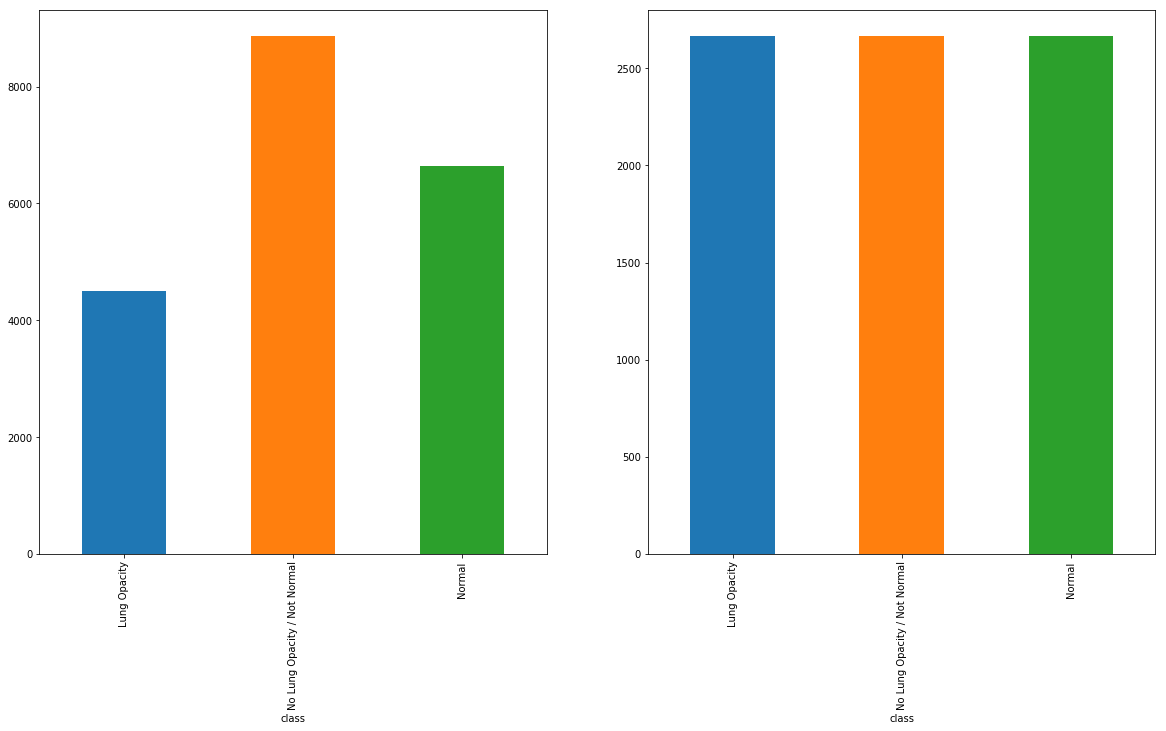

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
raw_train_df.groupby('class').size().plot.bar(ax=ax1)
train_df = raw_train_df.groupby('class').\
    apply(lambda x: x.sample(TRAIN_SAMPLES//3)).\
    reset_index(drop=True)
train_df.groupby('class').size().plot.bar(ax=ax2) 
print(train_df.shape[0], 'new training size')

## Keras Image Transplantation
Since Keras is design for color jpeg images we need to hack a bit to make it dicom friendly

In [14]:
try:
    # keras 2.2
    import keras_preprocessing.image as KPImage
except:
    # keras 2.1
    import keras.preprocessing.image as KPImage
    
from PIL import Image
import pydicom
def read_dicom_image(in_path):
    img_arr = pydicom.read_file(in_path).pixel_array
    return img_arr/img_arr.max()
    
class medical_pil():
    @staticmethod
    def open(in_path):
        if '.dcm' in in_path:
            c_slice = read_dicom_image(in_path)
            int_slice =  (255*c_slice).clip(0, 255).astype(np.uint8) # 8bit images are more friendly
            return Image.fromarray(int_slice)
        else:
            return Image.open(in_path)
    fromarray = Image.fromarray
KPImage.pil_image = medical_pil

# Data Augmentation
Here we can perform simple augmentation (the `imgaug` and `Augmentation` packages offer much more flexiblity). In order to setup the augmentation we need to know which model we are using

In [15]:
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

Using TensorFlow backend.


In [16]:
img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.05, 
                              width_shift_range = 0.02, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05,
                               preprocessing_function=preprocess_input)
img_gen = ImageDataGenerator(**img_gen_args)

In [17]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways: seed: {}'.format(seed))
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                              seed = seed,
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values,0)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [18]:
train_gen = flow_from_dataframe(img_gen, train_df, 
                             path_col = 'path',
                            y_col = 'class_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE)

valid_gen = flow_from_dataframe(img_gen, valid_df, 
                             path_col = 'path',
                            y_col = 'class_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
valid_X, valid_Y = next(flow_from_dataframe(img_gen, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'class_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = TEST_SAMPLES)) # one big batch

## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 7998 images
## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 6671 images
## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 6671 images


# Show a batch
Here we see what the augmentation actually looks like on a few sample images

(24, 384, 384, 3) (24, 3)


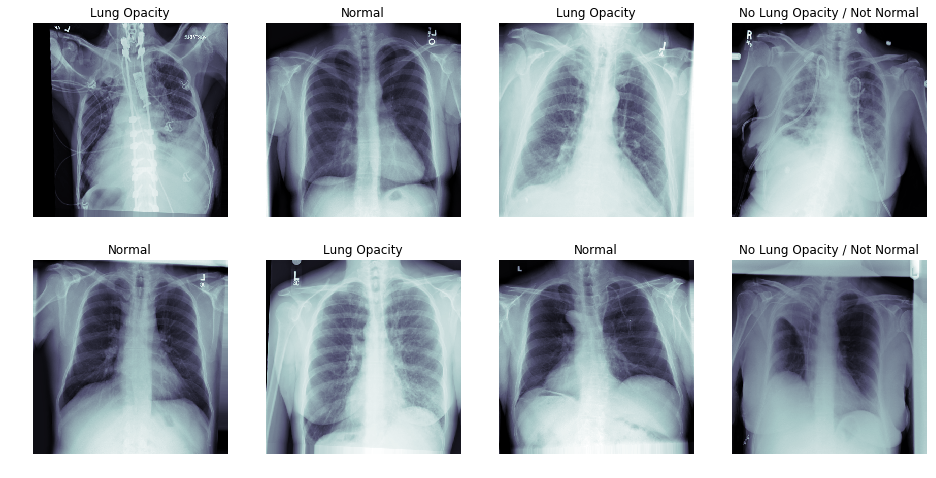

In [19]:
t_x, t_y = next(train_gen)
print(t_x.shape, t_y.shape)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title('%s' % class_enc.classes_[np.argmax(c_y)])
    c_ax.axis('off')

# Build our pretrained model
Here we build the pretrained model and download the weights

In [20]:
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


## Model Supplements
Here we add a few other layers to the model to make it better suited for the classification problem. 

In [21]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.models import Model
from keras.optimizers import Adam
from keras import layers
pt_features = Input(base_pretrained_model.get_output_shape_at(0)[1:], name = 'feature_input')
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)
gap = GlobalAveragePooling2D()(bn_features)

gap_dr = Dropout(DROPOUT)(gap)
dr_steps = Dropout(DROPOUT)(Dense(DENSE_COUNT, activation = 'linear', use_bias=False)(gap_dr))
dr_steps = BatchNormalization()(dr_steps)
dr_steps = layers.LeakyReLU(0.1)(dr_steps)
out_layer = Dense(t_y.shape[1], activation = 'softmax')(dr_steps)

attn_model = Model(inputs = [pt_features], 
                   outputs = [out_layer], name = 'trained_model')

attn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_input (InputLayer)   (None, 12, 12, 512)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 512)       2048      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65536     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
__________

In [22]:
from keras.models import Sequential
from keras.optimizers import Adam
pneu_model = Sequential(name = 'combined_model')
base_pretrained_model.trainable = False
pneu_model.add(base_pretrained_model)
pneu_model.add(attn_model)
pneu_model.compile(optimizer = Adam(lr = LEARN_RATE), loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])
pneu_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 12, 12, 512)       14714688  
_________________________________________________________________
trained_model (Model)        (None, 3)                 68483     
Total params: 14,783,171
Trainable params: 67,203
Non-trainable params: 14,715,968
_________________________________________________________________


In [23]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('lung_opacity')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=10, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/opt/conda/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/callbacks.py:1062: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


In [24]:
train_gen.batch_size = BATCH_SIZE
pneu_model.fit_generator(train_gen, 
                         steps_per_epoch=train_gen.n//BATCH_SIZE,
                         validation_data=(valid_X, valid_Y), 
                         epochs=20, 
                         callbacks=callbacks_list,
                         workers=2)

Epoch 1/20
333/333 [==============================] - 390s 1s/step - loss: 1.0223 - categorical_accuracy: 0.5218 - val_loss: 0.8841 - val_categorical_accuracy: 0.5675

Epoch 00001: val_loss improved from inf to 0.88412, saving model to lung_opacity_weights.best.hdf5
Epoch 2/20
333/333 [==============================] - 377s 1s/step - loss: 0.8785 - categorical_accuracy: 0.5921 - val_loss: 0.8232 - val_categorical_accuracy: 0.5900

Epoch 00002: val_loss improved from 0.88412 to 0.82316, saving model to lung_opacity_weights.best.hdf5
Epoch 3/20
333/333 [==============================] - 376s 1s/step - loss: 0.8355 - categorical_accuracy: 0.6054 - val_loss: 0.8070 - val_categorical_accuracy: 0.6000

Epoch 00003: val_loss improved from 0.82316 to 0.80698, saving model to lung_opacity_weights.best.hdf5
Epoch 4/20
333/333 [==============================] - 378s 1s/step - loss: 0.8131 - categorical_accuracy: 0.6214 - val_loss: 0.8038 - val_categorical_accuracy: 0.6063

Epoch 00004: val_loss i

In [25]:
pneu_model.load_weights(weight_path)
pneu_model.save('full_model.h5')

In [26]:
pred_Y = pneu_model.predict(valid_X, 
                          batch_size = BATCH_SIZE, 
                          verbose = True)

800/800 [==============================] - 8s 10ms/step


                              precision    recall  f1-score   support

                Lung Opacity       0.51      0.72      0.60       179
No Lung Opacity / Not Normal       0.68      0.42      0.52       342
                      Normal       0.70      0.84      0.76       279

                 avg / total       0.65      0.63      0.62       800



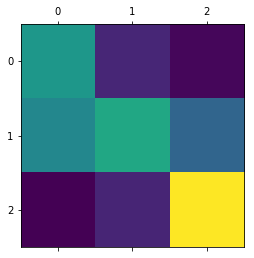

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(np.argmax(valid_Y, -1), np.argmax(pred_Y,-1)))
print(classification_report(np.argmax(valid_Y, -1), 
                            np.argmax(pred_Y,-1), target_names = class_enc.classes_))

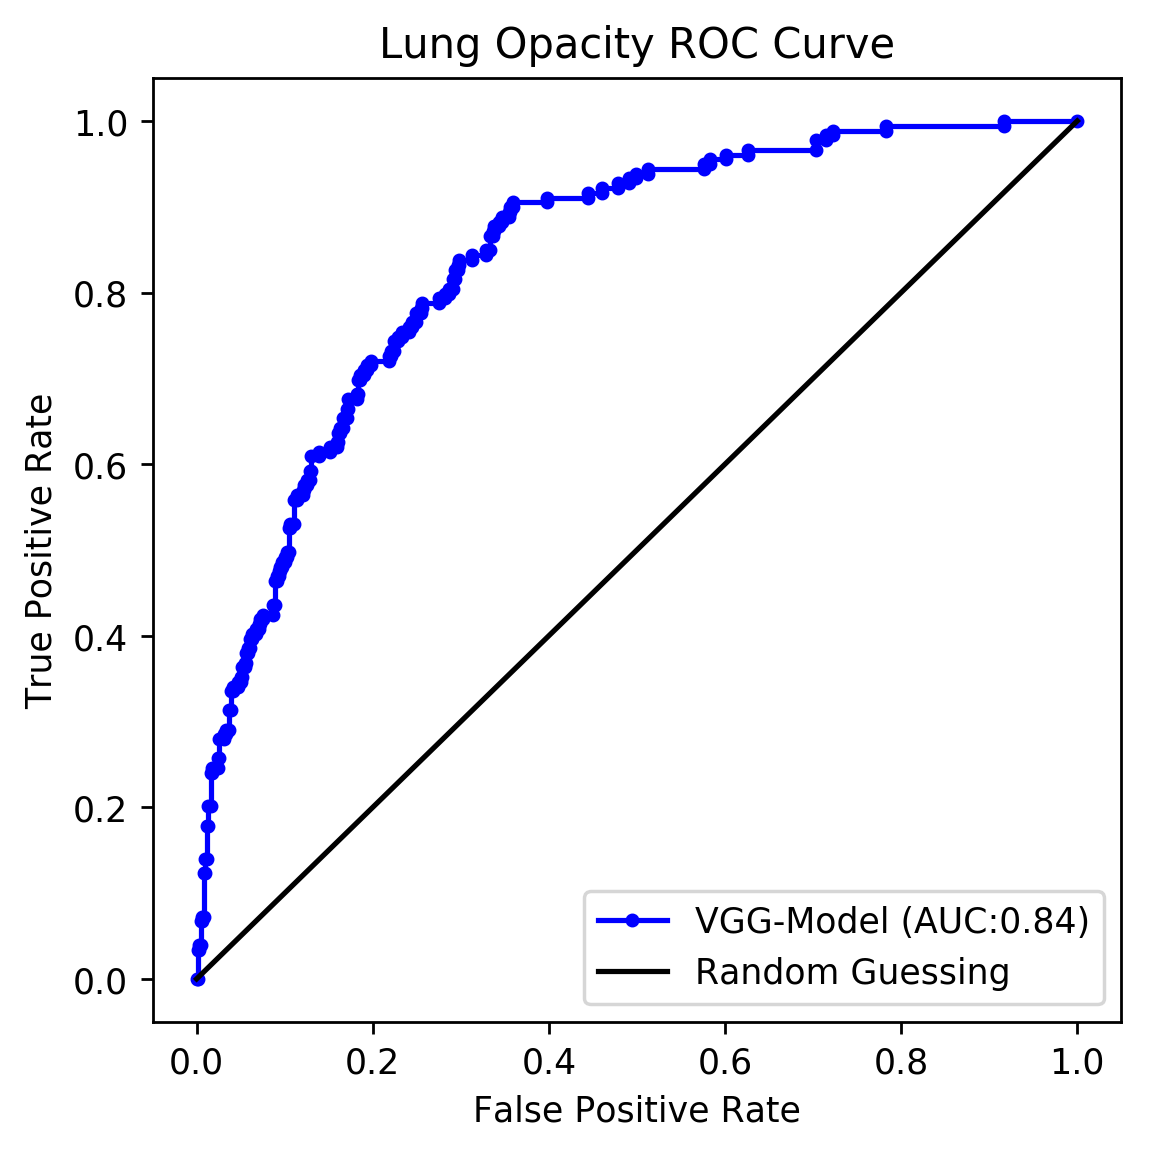

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(np.argmax(valid_Y,-1)==0, pred_Y[:,0])
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, 'b.-', label = 'VGG-Model (AUC:%2.2f)' % roc_auc_score(np.argmax(valid_Y,-1)==0, pred_Y[:,0]))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Lung Opacity ROC Curve')
fig.savefig('roc_valid.pdf')

# Make a submission
We load in the test images and make a submission using those images and a guess for $x, y$ and the width and height for all values where the model is more than 50% convinced there is something suspicious going on.

In [29]:
from glob import glob
sub_img_df = pd.DataFrame({'path': 
              glob('../input/rsna-pneumonia-detection-challenge/stage_2_test_images/*.dcm')})
sub_img_df['patientId'] = sub_img_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
sub_img_df.sample(3)

,path,patientId
97,../input/rsna-pneumonia-detection-challenge/st...,c12a8dab-bb32-4383-9ee3-bf2dce0fd20c
2764,../input/rsna-pneumonia-detection-challenge/st...,057a7499-4836-44ef-9490-56b002cd63c2
162,../input/rsna-pneumonia-detection-challenge/st...,c00b393c-87f3-46da-895b-823c290b0171


In [30]:
submission_gen = flow_from_dataframe(img_gen, 
                                     sub_img_df, 
                             path_col = 'path',
                            y_col = 'patientId', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE,
                                    shuffle=False)

## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3000 images


## Predict for each image twice and average the results
We shouldn't get the same answer since the data are being augmented (here at so-called test-time)

In [31]:
from tqdm import tqdm
sub_steps = 2*sub_img_df.shape[0]//BATCH_SIZE
out_ids, out_vec = [], []
for _, (t_x, t_y) in zip(tqdm(range(sub_steps)), submission_gen):
    out_vec += [pneu_model.predict(t_x)]
    out_ids += [t_y]
out_vec = np.concatenate(out_vec, 0)
out_ids = np.concatenate(out_ids, 0)

100%|██████████| 250/250 [05:10<00:00,  1.19s/it]


,patientId,Lung Opacity,No Lung Opacity / Not Normal,Normal
101,0133cd26-6796-48d3-a092-adae7ce07d61,0.571898,0.421392,0.006710
2971,c19eb270-ac17-48f3-bc22-9ba6fd38ac52,0.626988,0.353839,0.019173


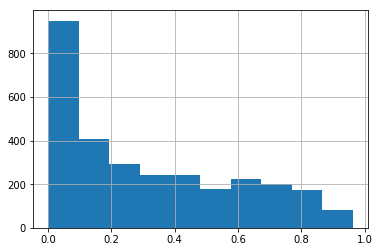

In [32]:
pred_df = pd.DataFrame(out_vec, columns=class_enc.classes_)
pred_df['patientId'] = out_ids
pred_avg_df = pred_df.groupby('patientId').agg('mean').reset_index()
pred_avg_df['Lung Opacity'].hist()
pred_avg_df.to_csv('image_level_class_probs.csv', index=False) # not hte submission file
pred_avg_df.sample(2)

### Simple Strategy
We use the `Lung Opacity` as our confidence and predict the image image. It will hopefully do a little bit better than a trivial baseline, and can be massively improved.

In [33]:
pred_avg_df['PredictionString'] = pred_avg_df['Lung Opacity'].map(lambda x: ('%2.2f 0 0 1024 1024' % x) if x>0.5 else '')

In [34]:
pred_avg_df[['patientId', 'PredictionString']].to_csv('submission.csv', index=False)

In [ ]:
!cp /kaggle/input/lung-opacity-overview/image_bbox_full.csv /kaggle/working/